# Machine Learning Nanodegree Capstone Project

### __by Gap Kim__

## Dataset for Project

In [1]:
### Sampling of training images
### Create train_sample.csv file with sampled train image url's

# reference Amanieu (https://www.kaggle.com/hyamanieu)

import pandas as pd
import numpy as np
import csv

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission = pd.read_csv("./sample_submission.csv")

### Get top 100 most frequently appearing landmark_id from the original dataset

In [2]:
rank_number = 100 # Number of top most frequent landmark_id for image selection
sampling_rate = 0.02 # fraction of images from each landmark_id
random_state = 17 # for reproducibility

landmarks=train_df.groupby(by='landmark_id').count().loc[:,'id']
l = landmarks.sort_values(ascending=False)

#l=landmarks.sample(frac=1,random_state=random_state)
lmks = pd.concat([l, l/l.sum(), l.cumsum()/l.sum()], axis=1, ignore_index=True)
lmks.columns=['Count', 'Proportion', 'CumSum']
ranked = lmks[0:rank_number]

train_ordered = train_df[train_df.landmark_id.isin(ranked.index)]
sample_gby = train_ordered.groupby(by='landmark_id').apply(lambda x: x.sample(frac=sampling_rate, random_state=random_state))
sample_idx = sample_gby.index.levels[1]
train_sample = train_df.iloc[sample_idx, :]

# write to csv file
train_sample.to_csv('train_sample.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
train_sample_df = pd.read_csv('train_sample.csv')

In [3]:
print("Total training data size:", train_df.shape[0])
print("Total test data size:", test_df.shape[0])
print("Total number of unique landmark_id's:", len(landmarks))

print("Sampled training data size:", train_sample.shape[0])
print("Sampled unique landmark_id's:", len(train_sample["landmark_id"].unique()))

Total training data size: 1225029
Total test data size: 117703
Total number of unique landmark_id's: 14951
Sampled training data size: 8158
Sampled unique landmark_id's: 100


In [4]:
train_sample.head()

,id,url,landmark_id
6,0aac70a1de44ced6,http://lh6.ggpht.com/-cJMh9AYQGk8/SOkF_Q5PrjI/...,9779
21,42ca212aeebe50f3,http://lh4.ggpht.com/-m0WQj_3hYm8/S97hjgI_iMI/...,2743
41,6e815d2054869066,https://lh4.googleusercontent.com/-gj2wg-G_7Ls...,1546
85,48988243139703b9,http://mw2.google.com/mw-panoramio/photos/medi...,4352
169,5756091a2a2f21c4,https://lh3.googleusercontent.com/-5YMebjnziuE...,6599


## EDA of Reduced Dataset

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

### Frequency of landmark_id in reduced dataset

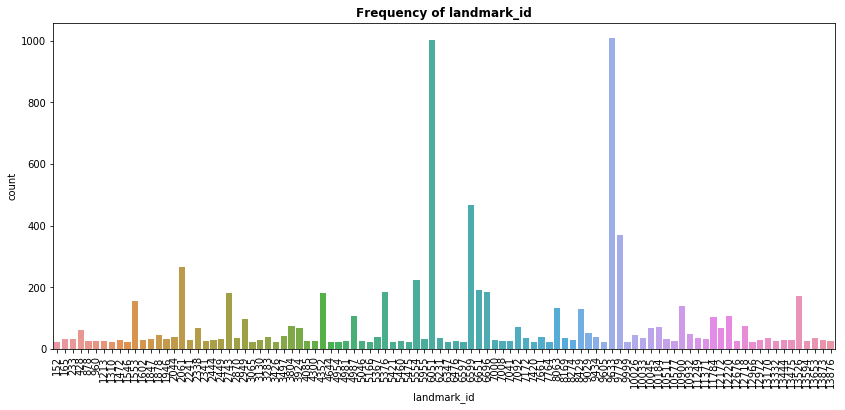

In [6]:
plt.figure(figsize = (14, 6))
g = sns.countplot(x="landmark_id", data=train_sample)
g.set_title("Frequency of landmark_id", fontweight="bold", fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [7]:
# Top 10 frequent landmark_ids

train_sample['landmark_id'].value_counts()[:10]

9633    1007
6051    1003
6599     468
9779     369
2061     265
5554     223
6651     190
6696     184
5376     184
2743     180
Name: landmark_id, dtype: int64

In [8]:
train_sample.nunique()

id             8158
url            8158
landmark_id     100
dtype: int64

### Two plots with the same landmark

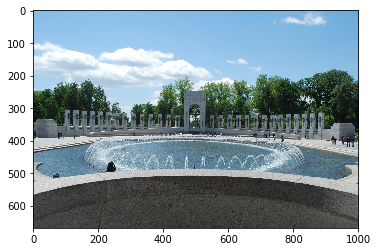

In [9]:
import cv2

img = cv2.imread('./train_images/cc7258ede5a819d8.jpg')
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

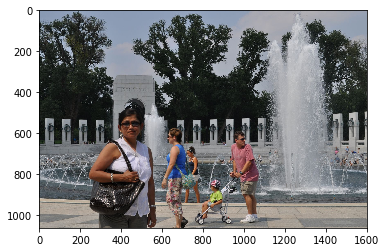

In [10]:
img = cv2.imread('./train_images/dff13c78c1c70d62.jpg')
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

## Create train, validation and test dataset

### Stratified sampling of training, validation and test dataset with 0.8, 0.1 and 0.1 split

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

X = train_sample_df['id']
y = train_sample_df['landmark_id']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

for train_id, test_id in sss.split(X, y):
    X_train, X_tmp = X.iloc[train_id], X.iloc[test_id]
    y_train, y_tmp = y.iloc[train_id], y.iloc[test_id]

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=10)

for train_id, test_id in sss1.split(X_tmp, y_tmp):
    X_valid, X_test = X_tmp.iloc[train_id], X_tmp.iloc[test_id]
    y_valid, y_test = y_tmp.iloc[train_id], y_tmp.iloc[test_id]

### Frequency of landmark_id in training dataset

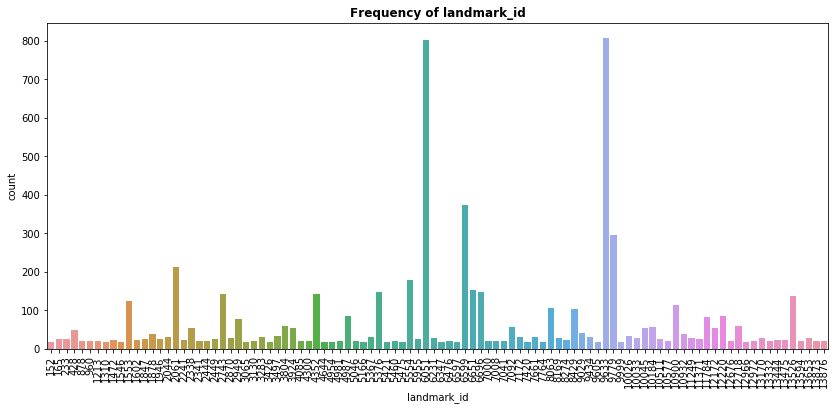

In [12]:
plt.figure(figsize = (14, 6))
h = sns.countplot(x=y_train)
h.set_title("Frequency of landmark_id", fontweight="bold", fontsize=12)
plt.xticks(rotation=90)
plt.show()

### Frequency of landmark_id in test dataset

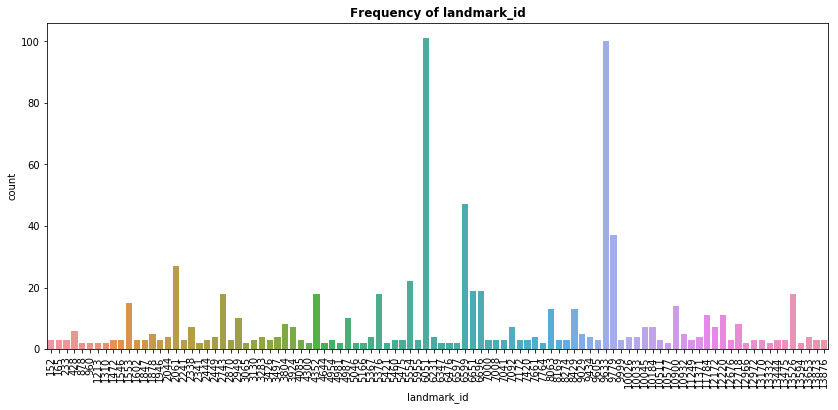

In [13]:
plt.figure(figsize = (14, 6))
h = sns.countplot(x=y_test)
h.set_title("Frequency of landmark_id", fontweight="bold", fontsize=12)
plt.xticks(rotation=90)
plt.show()

## Benchmark Model (Random Guessing)
### Expected accuracy

In [14]:
from itertools import combinations

def expected_acc(prob_id):
    
    prob_id_c = 1 - prob_id
    prob_correct_number = []

    for i in range(len(prob_id)+1):

        id_comb = list(combinations(range(len(prob_id)), r=i))
        id_notcomb = [tuple(set(range(len(prob_id)))^set(x)) for x in id_comb]

        prob_comb = np.array([[prob_id[x] for x in id_comb[i]] for i in range(len(id_comb))])
        prob_notcomb = np.array([[prob_id_c[x] for x in id_notcomb[i]] for i in range(len(id_notcomb))])

        prob_num = np.hstack((prob_comb, prob_notcomb))
        ss = sum([np.prod(x) for x in prob_num])

        prob_correct_number.append(ss)

    expected_correct_num = sum(np.array(range(len(prob_id)+1)) * np.array(prob_correct_number))
    expected_accuracy = expected_correct_num / len(prob_id)
    
    return([expected_correct_num, expected_accuracy])

### Monte Carlo simulation of expected accuracy

In [15]:
import random

### Calculate probability of correctly classifying a landmark_id, P(id)

# prob_id = np.array([0.25, 0.1]) # Example tryout given the probability of two images

prob_id = np.array([(y_test == id).sum() / len(y_test) for id in y_test]) # Calculates probabilities of all landmark_id
seed = [3, 10, 27, 31, 48, 55, 67, 95, 105, 117]

expected_val_df = pd.DataFrame(columns=['E(x)', 'Accuracy'])

for i in seed:
    
    random.seed(i)
    randsample = random.sample(range(len(y_test)), 20)
    
    prob_id_montecarlo = prob_id[randsample]  # random selection of 20 images (instead of total test dataset)
    expected_val_df.loc[len(expected_val_df)] = expected_acc(prob_id_montecarlo)

In [16]:
expected_val_df

,E(x),Accuracy
0,1.208333,0.060417
1,0.787990,0.039400
2,0.504902,0.025245
3,0.492647,0.024632
4,0.745098,0.037255
5,1.028186,0.051409
6,0.878676,0.043934
7,1.044118,0.052206
8,0.729167,0.036458
9,0.492647,0.024632


In [17]:
round(expected_val_df.T,3)

,0,1,2,3,4,5,6,7,8,9
E(x),1.208,0.788,0.505,0.493,0.745,1.028,0.879,1.044,0.729,0.493
Accuracy,0.060,0.039,0.025,0.025,0.037,0.051,0.044,0.052,0.036,0.025


In [18]:
expected_val_df.mean()

E(x)        0.791176
Accuracy    0.039559
dtype: float64

## Create Train, Validation and Test Tensors for CNN

In [19]:
import os
from keras.preprocessing import image                  
from tqdm import tqdm

img_shape = (192, 256) # Image shape (height, width)

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=img_shape)
    
    # convert PIL.Image.Image type to 3D tensor with shape (192, 256, 3)
    x = image.img_to_array(img)
    
    # convert 3D tensor to 4D tensor with shape (1, 192, 256, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

Using TensorFlow backend.


In [20]:
from glob import glob
import os

# define function to load train, test, and validation datasets
train_path = './train_images/'
valid_path = './valid_images/'
test_path = './test_images/'

def load_dataset(path, train_sample):
    file_out = sorted(glob(path + '*'))
    file_out = np.array([s.replace("\\", "/") for s in file_out])
    
    label_out = pd.Series(name="landmark_id")
    
    for file in file_out:
        filebase = os.path.basename(file)
        name = os.path.splitext(filebase)[0]
        temp = train_sample.landmark_id[train_sample["id"] == name]
        label_out = label_out.append(temp)
        
    label_out = np.array(pd.get_dummies(label_out))
    
    return file_out, label_out

In [21]:
train_file, train_target = load_dataset(train_path, train_sample)
valid_file, valid_target = load_dataset(valid_path, train_sample)
test_file, test_target = load_dataset(test_path, train_sample)

In [22]:
print("Number of training images:", len(train_target))
print("Number of validation images:", len(valid_target))
print("Number of test images:", len(test_target))

Number of training images: 6480
Number of validation images: 805
Number of test images: 809


In [23]:
train_tensors = paths_to_tensor(train_file).astype('float32')/255
valid_tensors = paths_to_tensor(valid_file).astype('float32')/255
test_tensors = paths_to_tensor(test_file).astype('float32')/255

100%|██████████| 809/809 [00:17<00:00, 47.12it/s]


In [24]:
train_tensors.shape

(6480, 192, 256, 3)

### An exmple image of a train tensor and label

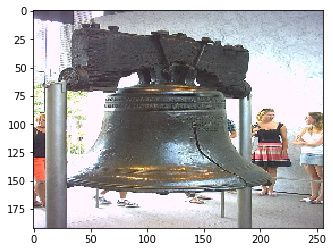

In [25]:
plt.imshow(train_tensors[2])

In [26]:
train_target[2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

## Base CNN Model
### Model Compile

In [27]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [28]:
input_shape = img_shape + (3,)

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=4, padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(100, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 192, 256, 16)      784       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 128, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 128, 32)       4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 32, 128)       32896     
__________

In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Model Train

In [30]:
from keras.callbacks import ModelCheckpoint

epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_baseCNN.hdf5', 
                               verbose=1, save_best_only=True)

hist = model.fit(train_tensors, train_target, 
          validation_data=(valid_tensors, valid_target),
          epochs=epochs, batch_size=64, callbacks=[checkpointer], verbose=1)

Train on 6480 samples, validate on 805 samples
Epoch 1/10
6480/6480 [==============================] - 29s - loss: 3.9288 - acc: 0.1285 - val_loss: 3.7904 - val_acc: 0.1615
Epoch 2/10
6480/6480 [==============================] - 25s - loss: 3.7063 - acc: 0.1750 - val_loss: 3.5604 - val_acc: 0.1888
Epoch 3/10
6480/6480 [==============================] - 25s - loss: 3.3824 - acc: 0.2233 - val_loss: 3.2344 - val_acc: 0.2311
Epoch 4/10
6480/6480 [==============================] - 25s - loss: 3.0999 - acc: 0.2738 - val_loss: 3.0491 - val_acc: 0.2696
Epoch 5/10
6480/6480 [==============================] - 25s - loss: 2.7220 - acc: 0.3440 - val_loss: 2.8700 - val_acc: 0.3317
Epoch 6/10
6480/6480 [==============================] - 25s - loss: 2.3239 - acc: 0.4196 - val_loss: 2.5428 - val_acc: 0.3925
Epoch 7/10
6480/6480 [==============================] - 24s - loss: 1.8522 - acc: 0.5228 - val_loss: 2.5804 - val_acc: 0.4211
Epoch 8/10
6480/6480 [==============================] - 24s - loss: 1.3

### Test Accuracy

In [31]:
model.load_weights('saved_models/weights.best.from_baseCNN.hdf5')

landmark_pred = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
test_accuracy = np.sum(np.array(landmark_pred) == np.argmax(test_target, axis=1)) / len(landmark_pred)
print('Test accuracy:', test_accuracy)

Test accuracy: 0.38566131026


## Data Augmentation

### Model Train

In [32]:
train_datagen = ImageDataGenerator(
    rotation_range=45, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    zoom_range=0.3)

valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_tensors, train_target, batch_size= 128)
valid_generator = valid_datagen.flow(valid_tensors, valid_target, batch_size= 128)

In [33]:
epochs_aug = 50

hist_aug = model.fit_generator(train_generator, steps_per_epoch=6480//128, epochs=epochs_aug,
                    validation_data=valid_generator, validation_steps=805//128,
                    callbacks=[checkpointer], verbose=1)

Epoch 1/50
50/50 [==============================] - 51s - loss: 3.1826 - acc: 0.2586 - val_loss: 2.6601 - val_acc: 0.3594
Epoch 2/50
50/50 [==============================] - 49s - loss: 2.9441 - acc: 0.2930 - val_loss: 2.5424 - val_acc: 0.4136
Epoch 3/50
50/50 [==============================] - 49s - loss: 2.8792 - acc: 0.3167 - val_loss: 2.4347 - val_acc: 0.4417
Epoch 4/50
50/50 [==============================] - 50s - loss: 2.7545 - acc: 0.3417 - val_loss: 2.3624 - val_acc: 0.4151
Epoch 5/50
50/50 [==============================] - 48s - loss: 2.6552 - acc: 0.3584 - val_loss: 2.3634 - val_acc: 0.4210
Epoch 6/50
50/50 [==============================] - 49s - loss: 2.6743 - acc: 0.3490 - val_loss: 2.2281 - val_acc: 0.4535
Epoch 7/50
50/50 [==============================] - 48s - loss: 2.5500 - acc: 0.3788 - val_loss: 2.3382 - val_acc: 0.4328
Epoch 8/50
50/50 [==============================] - 49s - loss: 2.5131 - acc: 0.3840 - val_loss: 2.1813 - val_acc: 0.4648
Epoch 9/50
50/50 [======

50/50 [==============================] - 49s - loss: 1.5362 - acc: 0.5912 - val_loss: 1.6318 - val_acc: 0.6041
Epoch 31/50
50/50 [==============================] - 48s - loss: 1.4670 - acc: 0.6063 - val_loss: 1.5836 - val_acc: 0.6233
Epoch 32/50
50/50 [==============================] - 49s - loss: 1.4754 - acc: 0.5959 - val_loss: 1.5636 - val_acc: 0.6233
Epoch 33/50
50/50 [==============================] - 49s - loss: 1.4519 - acc: 0.6138 - val_loss: 1.4807 - val_acc: 0.6248
Epoch 34/50
50/50 [==============================] - 48s - loss: 1.4140 - acc: 0.6204 - val_loss: 1.5343 - val_acc: 0.6086
Epoch 35/50
50/50 [==============================] - 48s - loss: 1.3877 - acc: 0.6213 - val_loss: 1.5082 - val_acc: 0.6233
Epoch 36/50
50/50 [==============================] - 49s - loss: 1.3577 - acc: 0.6330 - val_loss: 1.4968 - val_acc: 0.6367
Epoch 37/50
50/50 [==============================] - 49s - loss: 1.3373 - acc: 0.6317 - val_loss: 1.4605 - val_acc: 0.6366
Epoch 38/50
50/50 [=========

### Test Accuracy

In [47]:
model.load_weights('saved_models/weights.best.from_baseCNN.hdf5')

landmark_pred = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
landmark_prob = [np.amax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
test_accuracy = np.sum(np.array(landmark_pred) == np.argmax(test_target, axis=1)) / len(landmark_pred)
print('Test accuracy:', test_accuracy)

Test accuracy: 0.634116192831


## Global Average Precision (GAP) Evaluation

In [48]:
# Sort the predicted landmark lable and test label based on softmax probability

sort_id = np.argsort(landmark_prob)[::-1]
landmark_pred_sorted = [landmark_pred[sid] for sid in sort_id]
test_target_sorted = [test_target[sid] for sid in sort_id]

In [49]:
# Calculate GAP score

prec = []

for i in range(len(sort_id)):
    prec.append(np.sum(np.array(landmark_pred_sorted[:(i+1)]) == np.argmax(test_target_sorted[:(i+1)], axis=1)) 
                / len(landmark_pred_sorted[:(i+1)]))

GAP_score = np.sum(prec) / len(prec)
GAP_score

0.88080600137827803

## CNN with Batch Normalization
### Model Compile

In [35]:
modelBN = Sequential()

modelBN.add(Conv2D(filters=16, kernel_size=4, padding='same', use_bias=False, input_shape=input_shape))
modelBN.add(Activation("relu"))
modelBN.add(BatchNormalization())
modelBN.add(MaxPooling2D(pool_size=2))

modelBN.add(Conv2D(filters=32, kernel_size=3, padding='same', use_bias=False))
modelBN.add(Activation("relu"))
modelBN.add(BatchNormalization())
modelBN.add(MaxPooling2D(pool_size=2))

modelBN.add(Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False))
modelBN.add(Activation("relu"))
modelBN.add(BatchNormalization())
modelBN.add(MaxPooling2D(pool_size=2))

modelBN.add(Conv2D(filters=128, kernel_size=2, padding='same', use_bias=False))
modelBN.add(Activation("relu"))
modelBN.add(BatchNormalization())
modelBN.add(MaxPooling2D(pool_size=2))

modelBN.add(Flatten())
modelBN.add(Dense(512, activation='relu'))
modelBN.add(Dropout(0.3))
modelBN.add(Dense(100, activation='softmax'))

modelBN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 192, 256, 16)      768       
_________________________________________________________________
activation_1 (Activation)    (None, 192, 256, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 256, 16)      64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 96, 128, 16)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 128, 32)       4608      
_________________________________________________________________
activation_2 (Activation)    (None, 96, 128, 32)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 128, 32)       128       
__________

In [36]:
adam = optimizers.Adam(lr=0.02)
modelBN.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

### Model Train

In [50]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_BatchNorm.hdf5', 
                               verbose=1, save_best_only=True)

epochs_batch = 15

hist_BN = modelBN.fit(train_tensors, train_target, 
          validation_data=(valid_tensors, valid_target),
          epochs=epochs_batch, batch_size=64, callbacks=[checkpointer], verbose=1)

Train on 6480 samples, validate on 805 samples
Epoch 1/15
6480/6480 [==============================] - 32s - loss: 2.0588 - acc: 0.4867 - val_loss: 3.5970 - val_acc: 0.3242
Epoch 2/15
6480/6480 [==============================] - 31s - loss: 1.7909 - acc: 0.5483 - val_loss: 3.6500 - val_acc: 0.3106
Epoch 3/15
6480/6480 [==============================] - 32s - loss: 1.5186 - acc: 0.6015 - val_loss: 3.5653 - val_acc: 0.3267
Epoch 4/15
6480/6480 [==============================] - 31s - loss: 1.2618 - acc: 0.6583 - val_loss: 3.7138 - val_acc: 0.3019
Epoch 5/15
6480/6480 [==============================] - 31s - loss: 1.0235 - acc: 0.7151 - val_loss: 3.6630 - val_acc: 0.3317
Epoch 6/15
6480/6480 [==============================] - 31s - loss: 0.8303 - acc: 0.7639 - val_loss: 3.8044 - val_acc: 0.3416
Epoch 7/15
6480/6480 [==============================] - 31s - loss: 0.6622 - acc: 0.8174 - val_loss: 3.7389 - val_acc: 0.3466
Epoch 8/15
6480/6480 [==============================] - 31s - loss: 0.5

### Test Acccuracy

In [51]:
modelBN.load_weights('saved_models/weights.best.from_BatchNorm.hdf5')

landmark_pred = [np.argmax(modelBN.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]
test_accuracy = np.sum(np.array(landmark_pred) == np.argmax(test_target, axis=1)) / len(landmark_pred)
print('Test accuracy:', test_accuracy)

Test accuracy: 0.313967861557


## Model Evaluation

In [39]:
hist_BaseCNN = {'acc': [0.13132716049382717, 0.17654320987654321, 0.22330246913580246, 0.28456790123456788, 0.36003086419753089,
                        0.44645061728395063, 0.54243827160493829, 0.65416666666666667, 0.75169753086419755, 0.8246913580246914],
                'loss': [3.9298892386165667, 3.680104664814325, 3.3804817258575817, 3.066348374920127, 2.6730856707066666,
                         2.2241253917599901, 1.7646778118463211, 1.286705630502583, 0.87414459122551813, 0.60244603024588694],
                'val_acc': [0.17142857183580812, 0.19751552835754727, 0.24472049730164663, 0.29565217420921563,
                            0.37391304407060516, 0.3913043485294958, 0.43229813649787668, 0.4211180122742742,
                            0.42484472160753994, 0.41987577687879529],
                'val_loss': [3.7763777463332469, 3.5307922268506164, 3.2851792984127259, 2.9763647654041741, 2.737886569514778,
                             2.6325608985024211, 2.5756296847918021, 2.7493783006016512, 2.8917108950407608,3.2256962965734255]}

In [40]:
hist_BaseCNN_df = pd.DataFrame(hist_BaseCNN)
hist_BaseCNN_df.columns = ['Train_acc', 'Train_loss', 'Val_acc','Val_loss']
hist_BaseCNN_df

,Train_acc,Train_loss,Val_acc,Val_loss
0,0.131327,3.929889,0.171429,3.776378
1,0.176543,3.680105,0.197516,3.530792
2,0.223302,3.380482,0.244720,3.285179
3,0.284568,3.066348,0.295652,2.976365
4,0.360031,2.673086,0.373913,2.737887
5,0.446451,2.224125,0.391304,2.632561
6,0.542438,1.764678,0.432298,2.575630
7,0.654167,1.286706,0.421118,2.749378
8,0.751698,0.874145,0.424845,2.891711
9,0.824691,0.602446,0.419876,3.225696


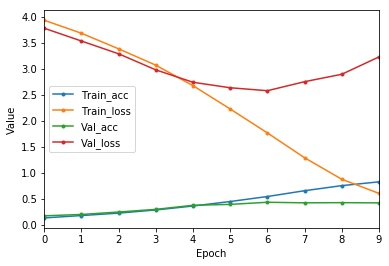

In [41]:
ax1 = hist_BaseCNN_df.plot(marker='.')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Value")
plt.savefig('./Report/base.png')

In [42]:
hist_Aug1 = {'acc': [0.25546875000000002, 0.29408060445893619, 0.30462846340100169, 0.33674433294411571, 0.34146725470833572,
                     0.35941435768261965, 0.35925692687707222, 0.38365868995111596, 0.38727959705239878, 0.40192065483676997,
                     0.4208123424191319, 0.42191435753248202, 0.43938916906601838, 0.45560453385490013, 0.46221662491034499,
                     0.46300377878794441, 0.49071158705190088, 0.48598866498740556, 0.50519521410579349, 0.51243702770780852,
                     0.51338161254109305, 0.53494962246652211, 0.5469143573823444, 0.54738665017433075, 0.54707178841309823,
                     0.55919395450981202, 0.57761335027608218, 0.58705919470534818, 0.58658690161308658, 0.59382871551537697,
                     0.60862720418036431, 0.61319269506396812, 0.60799748125844999, 0.62043450881612094, 0.61791561727860111,
                     0.62641687627403198, 0.63082493747812074, 0.6460957172835804, 0.650818640098764, 0.64798488710028701,
                     0.6527078087143694, 0.66593198977429557, 0.67726700341971757, 0.67742443324937029, 0.67333123395665162,
                     0.67553526448362722, 0.68246221707509802, 0.69285264483627207, 0.7029282120373147, 0.69899244302466179,
                     0.71630982307703128, 0.6985201511335013, 0.71048488634959872, 0.71656249999999999, 0.71505037813402839,
                     0.71977329974811088, 0.7282745596443676, 0.73646095747911655, 0.73803526478390247, 0.75409319944285624],
             'loss': [3.2232321786880491, 2.9990468968071924, 2.9238310268603884, 2.7992355565280098, 2.737023192028555,
                      2.6451771565588658, 2.6298042989197548, 2.5292290740409484, 2.4872682490937357, 2.4218320276034571,
                      2.3226811627596993, 2.299093459655416, 2.2177092599628554, 2.2043386424518654, 2.1157339285843317,
                      2.0904880164552395, 2.0064047355795989, 1.9939596881193837, 1.9514757896250381, 1.9008020567954036,
                      1.876178127392113, 1.782965435489299, 1.7345330483967472, 1.7294392582751641, 1.7163397094764998,
                      1.6662033177743329, 1.6024818057077057, 1.5661355632378413, 1.5691469054978802, 1.5227450225455335,
                      1.469195683597017, 1.4539444128271914, 1.4576934302784033, 1.4022760595422548, 1.3867993583006581,
                      1.3635792876370909, 1.3296321273150311, 1.2845476106071954, 1.265174487676068, 1.2719144436814622,
                      1.2758843298222615, 1.2146366297147737, 1.1755962930338208, 1.163139341460067, 1.1503687775705562,
                      1.1531679134825314, 1.1188850982363339, 1.0898135984574517, 1.0535212247738008, 1.0678208411790862,
                      1.0192861403866438, 1.0809404141356422, 1.0331504585160416, 0.98859515905380246, 1.00419298527523,
                      0.99700506358062591, 0.96955797684282741, 0.93192633513539502, 0.91039594775183075, 0.87640107939165246],
             'val_acc': [0.3828125, 0.39438700367816265, 0.39881831830150094, 0.41802068092094036, 0.44313146339033344,
                         0.46233382715432297, 0.4357459379175741, 0.45963541666666669, 0.49778434414102901, 0.46971935113036301,
                         0.48596750562969304, 0.50516986899749217, 0.50516986987791523, 0.56129985396231652,0.54036458333333337,
                         0.52437223298158742, 0.52732644299460651, 0.55096012248246318, 0.5509601204574901, 0.57607090182635423,
                         0.56129985721988196, 0.5703125, 0.58345642646271156, 0.60265879071093376, 0.58345642646271156,
                         0.59084195171536513, 0.60856720959242194, 0.59379616120013035, 0.62239583333333337,0.64106351806282824,
                         0.61595273519724481, 0.64254062117642807, 0.61742983654999839, 0.66469719640613478,
                         0.62629246579667486, 0.62630208333333337, 0.64844904129050862, 0.63810930505637053,
                         0.62924667906725951, 0.673559824420219, 0.6528803561779738, 0.64401772605087415, 0.65625,
                         0.64254062267314738, 0.63515509856504382, 0.64844904155463556, 0.66322008880237704, 0.6661743015447078,
                         0.68537666227123761, 0.65625, 0.66322008941867328, 0.68094534703160314, 0.67355982265937275,
                         0.70162481439342528, 0.68833087492552603, 0.68389955678049541, 0.68489583333333337, 0.692762186643468,
                         0.68537666517663387, 0.67651403478540728],
             'val_loss': [2.6452309290568032, 2.5847700216217264, 2.4060148689208036, 2.3356332831756053, 2.3420486395609079,
                          2.3017310786282472, 2.3716619233084923, 2.2140320539474487, 2.0899026453759153, 2.1580345694036218,
                          2.0487872564634158, 2.0332463872309448, 2.0096049868725956, 1.9020438509466377, 1.9020523428916931,
                          1.8518806903717966, 1.7829044162786869, 1.8370949434917117, 1.845528794180167, 1.7594302035152825,
                          1.8055269017353368, 1.6822096308072407, 1.7357862992335986, 1.6300792472225172, 1.7285163599772151,
                          1.6977536676553362, 1.6085897534425362, 1.6361149172663161, 1.5901709794998169, 1.484190075929267,
                          1.5790710727432453, 1.5120298226791788, 1.4797959715964346, 1.4832501860453775, 1.5785681849216253,
                          1.554775059223175, 1.4138278459340465, 1.3956891520160692, 1.5429726955281402, 1.3938687219225321,
                          1.4762555027994131, 1.4691717006607281, 1.4483438928922017, 1.4830871012221412, 1.4592810141987427,
                          1.4282475282029528, 1.425352577796891, 1.337258996780373, 1.3461823303202936, 1.4805522759755452,
                          1.3543041685659389, 1.2878402416075703, 1.391042958510327, 1.3276069699573376, 1.279264172035623,
                          1.3356382948961356, 1.367376983165741, 1.3885350897357946, 1.4288017251466896, 1.3429765403710934]}

In [43]:
hist_Aug1_df = pd.DataFrame(hist_Aug1)
hist_Aug1_df.columns = ['Train_acc', 'Train_loss', 'Val_acc','Val_loss']
hist_Aug1_df.head()

,Train_acc,Train_loss,Val_acc,Val_loss
0,0.255469,3.223232,0.382812,2.645231
1,0.294081,2.999047,0.394387,2.584770
2,0.304628,2.923831,0.398818,2.406015
3,0.336744,2.799236,0.418021,2.335633
4,0.341467,2.737023,0.443131,2.342049


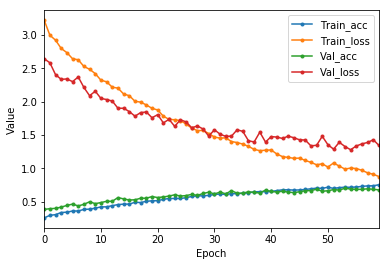

In [44]:
ax2 = hist_Aug1_df.plot(marker='.')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Value")
plt.savefig('./Report/aug.png')